In [2]:
import random
import string
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import numpy.matlib as npmatlib
%matplotlib inline

import dataloader
import util

from scipy.optimize import minimize

#load data
dataset = dataloader.DataLoader(verbose=True)
x_train, x_test, y_train, y_test, y_reg_train, y_reg_test = dataset.load_data()

#vectorize the images and data
x_train = np.reshape(x_train, [x_train.shape[0], x_train.shape[1]*x_train.shape[2]]).T
x_test = np.reshape(x_test, [x_test.shape[0], x_test.shape[1]*x_test.shape[2]]).T
y_reg_train = y_reg_train.T
y_reg_test = y_reg_test.T

#forward model (i.e. simualator)
G = np.load('G.npy')

#linear least square solution
sz = 28
ref = 3
num_samples = 100

#dobs
d_obs = np.squeeze(np.multiply(y_reg_test[:, ref:ref+1], np.expand_dims(dataset.maxs, axis=-1)))
m_ref = np.squeeze(x_test[:, ref:ref+1])

#color by label
my_cmap = cm.get_cmap('jet')
my_norm = Normalize(vmin=0, vmax=9)
cs = my_cmap(my_norm(y_test))

print(x_train.shape)
print(x_test.shape)
print(y_reg_train.shape)
print(y_reg_test.shape)
print(G.shape)

print(d_obs.shape)
print(m_ref.shape)

Loaded training data x (60000, 28, 28, 1) and y (60000, 128) and y_labels (60000,)
Loaded testing data x (10000, 28, 28, 1) and y (10000, 128) and y_labels (10000,)
(784, 60000)
(784, 10000)
(128, 60000)
(128, 10000)
(784, 128)
(128,)
(784,)


In [3]:
#equation to solve
def func(m):
    return np.sqrt(np.mean(np.square(G.T@m - d_obs)))

#gradient of the equation
def dldm(m):
    return np.squeeze(G@(G.T@m - d_obs))

In [4]:
#callback to monitor optimization process
from IPython.display import clear_output

i = 0
x = []
losses = []
fig = plt.figure()
logs = []

def monitor(xk):
    
    global i, x, losses, logs

    logs.append(logs)
    x.append(i)
    losses.append(func(xk))
    i += 1
    clear_output(wait=True)
    plt.plot(x, losses, label="loss", c = 'green')
    plt.legend()
    plt.show()

<Figure size 432x288 with 0 Axes>

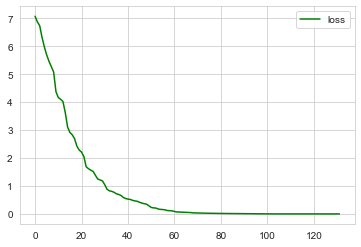

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 132
         Function evaluations: 519
         Gradient evaluations: 519
(784, 1)


In [5]:
#initial guess (sensitive!)
m0 = np.random.normal(size=m_ref.shape)*0.0
print(m0.shape)

#minimize the objective function
res = minimize(func, m0, method='BFGS', jac=dldm, callback=monitor, options={'gtol': 1e-6, 'disp': True})
m_sol = np.expand_dims(res.x, axis=-1)
print(m_sol.shape)

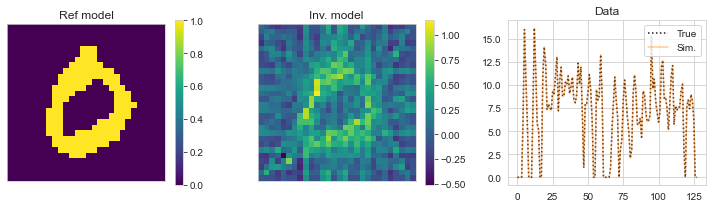

In [6]:
#forward simulation on the inverted model
y_sim = (m_sol.T@G).T

#compare model and data (i.e. reference case vs solution)
f = plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.imshow(np.reshape(m_ref, [sz, sz]), cmap="viridis", vmin=0, vmax=1, aspect='equal')
plt.xticks([]), plt.yticks([])
plt.colorbar()
plt.title("Ref model")

plt.subplot(1, 3, 2)
plt.imshow(np.reshape(m_sol, [sz, sz]), cmap="viridis", aspect='equal')
plt.xticks([]), plt.yticks([])
plt.colorbar()
plt.title("Inv. model")

plt.subplot(1, 3, 3)
plt.plot(np.squeeze(np.multiply(y_reg_test[:, ref:ref+1], np.expand_dims(dataset.maxs, axis=-1))), ls=':', c='k', label='True', alpha=0.9)
plt.plot(y_sim, c=cs[y_test[ref]], label='Sim.', alpha=0.4)
#plt.ylim([0, 1])
plt.title("Data")
plt.legend()

plt.tight_layout()